# Data Analysis
--------------------
Question 1: Is there a relationship between exposure to poor air quality and incidences of cancer?

Question 2: Does your probability of developing a certain type of cancer change depending on your geographic location in the US?

Question 3: How well can you predict (cancer instances/risk/rate) from AQI and year?

In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from config import state_abbrev, reverse_state_abbrev, state_codes, make_scatterplot, generate_county_choropleth, scale

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

import statsmodels as sm
import sklearn as sk
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.formula.api as smf
from scipy import stats

import zipfile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
# Read in data
aqi = pd.read_csv("clean_data/aqi_1980_2018.csv", index_col=0)        # AQI data by state/county: 1980-2018
cancer = pd.read_csv("clean_data/cancer_1998_2014.csv", index_col=0)  # Cancer data by state: 1998-2014
print("AQI Data Headers:\n", aqi.keys().tolist())
print("\nCancer Data Headers:\n", cancer.keys().tolist())

AQI Data Headers:
 ['State', 'County', 'State Abbreviation', 'Year', 'FIPS', 'State FIPS Code', 'County FIPS Code', 'Max AQI', '90th Percentile AQI', '% Days AQI Unhealthy-Hazardous', '% Days CO', '% Days NO2', '% Days SO2', '% Days Ozone', '% Days PM2.5', '% Days PM10']

Cancer Data Headers:
 ['State', 'State Abbreviation', 'Year', 'Cancer Sites', 'Count']


## How has air quality changed since 1980?
------
This choropleth displays a map of the average median AQI by each state for the period of 1980-2018. The purpose of the choropleth is to 
show a trend of increasing median AQI for an increasing number of states over the years. 

In [3]:
# The map displays a functioning slider and index, however the values/color gradient for the individual states is not displaying.  

# dataset = pd.read_csv('clean_data/county_aqi_1980_2018.csv')
# years = sorted(list(set(dataset.Year)))

# data = []

# for year in years:
#     df = dataset[dataset.Year ==year].copy(deep=True)
#     this_dict = dict(type='choropleth',
#              locations = df['State Abbreviation'].astype(str),
#              z=df['Median AQI'].astype(float), # for whatever reason the values of "Max AQI" are not displaying in the map.
#              locationmode="USA-states")
#     data.append(this_dict)
# # let's create the steps for the slider
# steps = []
# for i in range(len(data)):
#     step = dict(method='restyle',
#                 args=['visible', [False] * len(data)],
#                 label='Year {}'.format(i + 1980))
#     step['args'][1][i] = True
#     steps.append(step)

# sliders = [dict(active=0,
#                 pad={"t": 1},
#                 steps=steps)]    
# layout = dict(geo=dict(scope='usa',
#                        projection={'type': 'Mercator'}),
#               sliders=sliders)

# fig = dict(data=data, 
#            layout=layout)
# py.iplot(fig, validate=False)


/Users/alyss/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



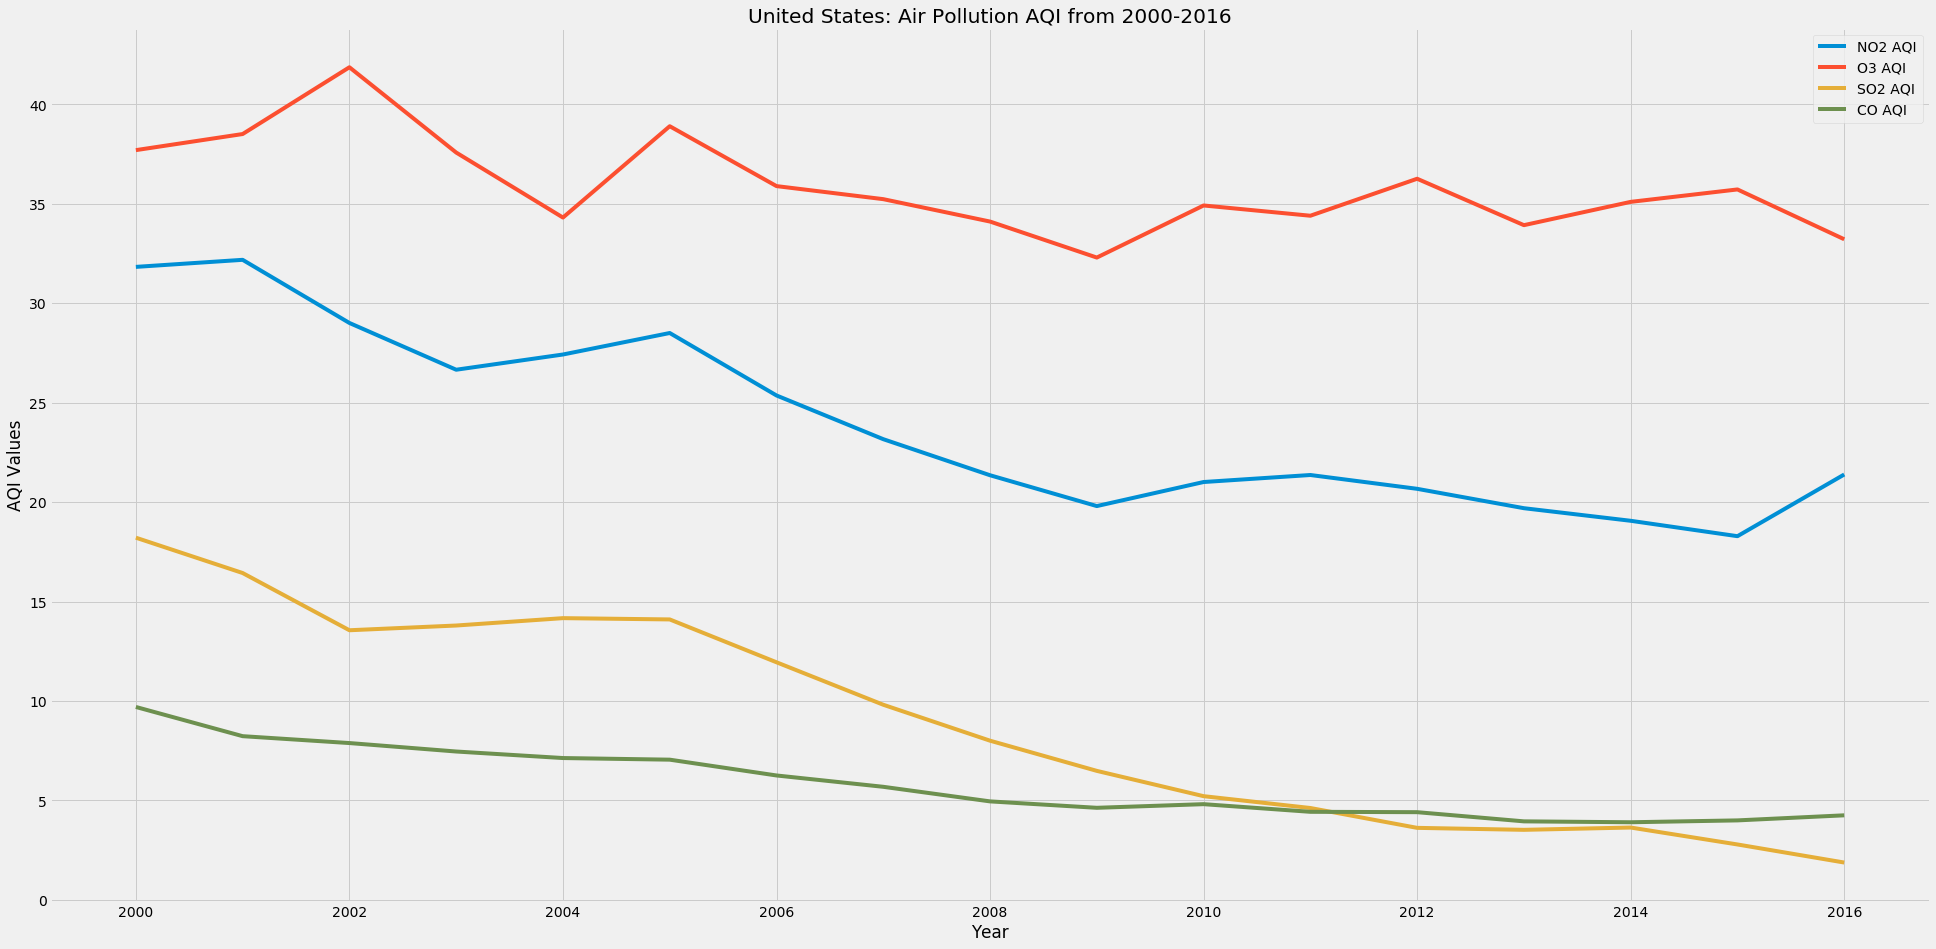

In [4]:
pollution_data = pd.read_csv("clean_data/pollution_us_2000_2016.csv", compression='gzip')

pollution_data_c = pollution_data.dropna(axis='rows')
pollution_data_c = pollution_data_c[pollution_data_c.State!='Country Of Mexico']
pollution_data_c['Date Local'] = pd.to_datetime(pollution_data_c['Date Local'],format='%Y-%m-%d')
pollution_data_c['Date Local'] = pollution_data_c['Date Local'].apply(str)
pollution_data_c['State Code'] = pollution_data_c['State Code'].apply(str)
pollution_data_c['County Code'] = pollution_data_c['County Code'].apply(str)
pollution_data_c['Year'] = pollution_data_c['Date Local'].apply(lambda x: x.split("-")[0])
pollution_data_c['Month'] = pollution_data_c['Date Local'].apply(lambda x: x.split("-")[1])
pollution_data_c['Day'] = pollution_data_c['Date Local'].apply(lambda x: x.split("-")[2])
pollution_data_c = pollution_data_c.rename(columns = {"State Code": "State Code (FIPS)"})
pollution_data_c['State Code (FIPS)'] = pollution_data_c['State Code (FIPS)'].apply(lambda x: str(x).zfill(2))
pollution_data_c['County Code'] = pollution_data_c['County Code'].apply(lambda x: str(x).zfill(3))
pollution_data_c['FIPS'] = pollution_data_c['State Code (FIPS)'] + pollution_data_c['County Code']
pollution_data_c['Year'] = pollution_data_c['Year'].apply(int)

pollution_data_c = pollution_data_c.groupby(['Year','State'], as_index=False).mean()

plt.style.use('fivethirtyeight')

pollution_data_c = pollution_data_c.groupby(['Year'])[['Year', 'NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']].mean()
pollution_data_c.plot(kind='line', x='Year', y=['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI'], figsize=(30, 15))
plt.title("United States: Air Pollution AQI from 2000-2016")
plt.ylabel("AQI Values")
plt.show()

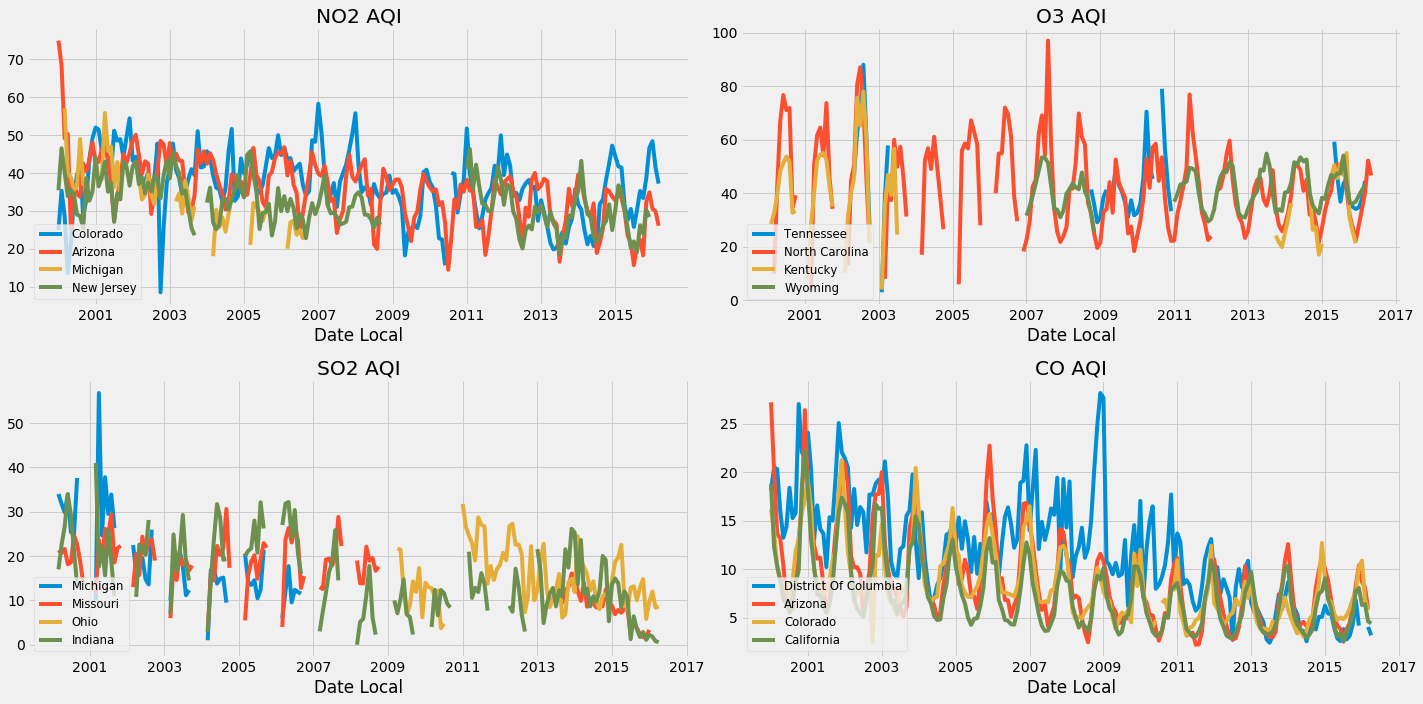

In [5]:
poll = pollution_data

## Prepare all 4 AQIs against state and date 
pollSt = poll[['State','Date Local','NO2 AQI','O3 AQI','SO2 AQI','CO AQI']]
pollSt = pollSt.dropna(axis='rows')  # Delete rows with NAs
pollSt = pollSt[pollSt.State!='Country Of Mexico']  # Delete Mexico
pollSt['Date Local'] = pd.to_datetime(pollSt['Date Local'],format='%Y-%m-%d')  # Change date from string to date value
pollSt = pollSt.groupby(['State','Date Local']).mean()  # Take mean values if there are depulicated entries
pollStGrouped = pollSt.groupby(level=0)

## Plot 4 AQIs with top 4 states
plt.figure(figsize=(20,10))

# NO2 AQI
plt.subplot(221)
pollNO2 = pollStGrouped['NO2 AQI']
pollNO2Top = pollNO2.mean().nlargest(4).index
for i in range(len(pollNO2Top)):
    pollNO2.get_group(pollNO2Top[i]).groupby(pd.Grouper(level='Date Local',freq='M')).mean().plot()
plt.legend(pollNO2Top,loc=3,fontsize='small')
plt.title('NO2 AQI')

# O3 AQI
plt.subplot(222)
pollO3 = pollStGrouped['O3 AQI']
pollO3Top = pollO3.mean().nlargest(4).index
for i in range(len(pollO3Top)):
    pollO3.get_group(pollO3Top[i]).groupby(pd.Grouper(level='Date Local',freq='M')).mean().plot()
plt.legend(pollO3Top,loc=3,fontsize='small')
plt.title('O3 AQI')

# SO2 AQI
plt.subplot(223)
pollSO2 = pollStGrouped['SO2 AQI']
pollSO2Top = pollSO2.mean().nlargest(4).index
for i in range(len(pollSO2Top)):
    pollSO2.get_group(pollSO2Top[i]).groupby(pd.Grouper(level='Date Local',freq='M')).mean().plot()
plt.legend(pollSO2Top,loc=3,fontsize='small')
plt.title('SO2 AQI')

# CO AQI
plt.subplot(224)
pollCO = pollStGrouped['CO AQI']
pollCOTop = pollCO.mean().nlargest(4).index
for i in range(len(pollCOTop)):
    pollCO.get_group(pollCOTop[i]).groupby(pd.Grouper(level='Date Local',freq='M')).mean().plot()
plt.legend(pollCOTop,loc=3,fontsize='small')
plt.title('CO AQI')

plt.tight_layout()
plt.show()

In [6]:
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []
months = ['2015-01-31','2015-02-28','2015-03-31','2015-04-30','2015-05-31','2015-06-30',
        '2015-07-31','2015-08-31','2015-09-30','2015-10-31','2015-11-30','2015-12-31']

pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
#     p['State_abbrev'] = p.State.apply(lambda x: us_state_abbrev[x])
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])

data=[]
layout = dict(
        title = 'Monthly Max AQI in 2015',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

########################## 2015 ##########################

In [7]:
########################## 2014 ##########################
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []

months = ['2014-01-31','2014-02-28','2014-03-31','2014-04-30',
            '2014-05-31','2014-06-30','2014-07-31','2014-08-31',
            '2014-09-30','2014-10-31','2014-11-30','2014-12-31']


pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])

data=[]
layout = dict(
        title = 'Monthly Max AQI in 2014',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

In [8]:
########################## 2013 ##########################
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []

months = ['2013-01-31','2013-02-28','2013-03-31','2013-04-30',
            '2013-05-31','2013-06-30','2013-07-31','2013-08-31',
            '2013-09-30','2013-10-31','2013-11-30','2013-12-31']

pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])
    
data=[]
layout = dict(
        title = 'Monthly Max AQI in 2013',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

In [9]:
########################## 2012 ##########################
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []
months = ['2012-01-31','2012-02-28','2012-03-31','2012-04-30',
            '2012-05-31','2012-06-30','2012-07-31','2012-08-31',
            '2012-09-30','2012-10-31','2012-11-30','2012-12-31']


pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])
    
data=[]
layout = dict(
        title = 'Monthly Max AQI in 2012',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

In [10]:
########################## 2011 ##########################
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []
months = ['2011-01-31','2011-02-28','2011-03-31','2011-04-30',
            '2011-05-31','2011-06-30','2011-07-31','2011-08-31',
            '2011-09-30','2011-10-31','2011-11-30','2011-12-31']


pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])
    
data=[]
layout = dict(
        title = 'Monthly Max AQI in 2011',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

In [11]:
########################## 2010 ##########################
## Create MaxAQI and MAXAQIValue that dipict the worst AQI and its value of the month
pMonth = []
months = ['2010-01-31','2010-02-28','2010-03-31','2010-04-30',
            '2010-05-31','2010-06-30','2010-07-31','2010-08-31',
            '2010-09-30','2010-10-31','2010-11-30','2010-12-31']


pollStMonth = pollSt.reset_index(level=0).groupby(['State']).resample('M').max().drop(['State'],axis=1)
pollStMonth = pollStMonth.reset_index()

for i,month in enumerate(months):
    p = pollStMonth[pollStMonth['Date Local']==month].copy()
    p['MaxAQIValue'] = p.max(axis=1)
    p['MaxAQI'] = p.drop(['State','Date Local'],axis=1).idxmax(axis=1)

    p = p[p['State']!='District Of Columbia']
    p['State_abbrev'] = p.State.apply(lambda x: reverse_state_abbrev[x])
    pMonth.append(p[p['MaxAQI'].notnull()])
    
data=[]
layout = dict(
        title = 'Monthly Max AQI in 2010',
        width = 1000,
        height = 600
)

for i in range(12):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    data.append(dict(
        type='choropleth',
        locationmode = 'USA-states',
        z = pMonth[i]['MaxAQIValue'],
        colorscale = scale(pMonth[i]['MaxAQIValue']),
        autocolorscale = False,
        locations = pMonth[i].State_abbrev,
        text = pMonth[i]['MaxAQI'].apply(lambda x:x[:-3]),
        showscale =False,
        geo=geo_key,
        marker = dict(line = dict(color='rgb(227,227,227)',width = 1.5)),
        ))
    
    data.append(dict(
        type = 'scattergeo',
        showlegend = False,
        lon = [-80],
        lat = [48],
        geo = geo_key,
        text = months[i][:-3],
        mode = 'text',
        ))
    layout[geo_key] = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            domain = dict( x = [], y = [] ),
            lakecolor = 'rgb(255, 255, 255)')
z = 0
COLS = 4
ROWS = 3
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1

figure = dict(data = data, layout = layout)
py.iplot(figure)

########################## NO MORE YEARS ##########################

---------------
### How does population affect air quality?
* To answer this question, the US 2010 census data was used to acquire population data for each county that we had on record from the EPA's Annual Air Quality Index (AQI) summary.
* There was more census data for the counties than there was for the AQI data. As a result, the data that is read in was cleaned to yield 2 common rows between each data frame ("County" and "State Code (FIPS)"). These two common rows were used to left merge the necessary dataframes to get the data series needed for plotting.

In [12]:
county_pop = pd.read_csv("raw_data/county_populations_census_2010-17.csv", encoding='latin-1')
county_pop = county_pop.rename(columns = {'April 1, 2010 - Census': '2010 Census',
                                          'April 1, 2010 - Estimates Base': 'Estimate Base',
                                          'Population Estimate (as of July 1) - 2010': '2010 Estimate',
                                          'Population Estimate (as of July 1) - 2011': '2011 Estimate',
                                          'Population Estimate (as of July 1) - 2012': '2012 Estimate',
                                          'Population Estimate (as of July 1) - 2013': '2013 Estimate',
                                          'Population Estimate (as of July 1) - 2014': '2014 Estimate',
                                          'Population Estimate (as of July 1) - 2015': '2015 Estimate',
                                          'Population Estimate (as of July 1) - 2016': '2016 Estimate',
                                          'Population Estimate (as of July 1) - 2017': '2017 Estimate'})
county_pop["County"] = county_pop['Geography'].apply(lambda x: x.split(", ")[0].lower())
county_pop["County"] = county_pop["County"].apply(lambda x: x.replace(" county", ""))
county_pop["County"] = county_pop["County"].apply(lambda x: x.replace(" parish", ""))
county_pop["State"] = county_pop['Geography'].apply(lambda x: x.split(", ")[-1])
# county_pop = county_pop.replace({"State": reverse_state_abbrev})
county_pop["State"] = county_pop["State"].apply(lambda x: reverse_state_abbrev[x])
county_pop = county_pop.replace({"State": state_codes})
county_pop = county_pop.rename(columns = {"State": "State Code (FIPS)"})
county_pop.head()

,Id,Id2,Geography,2010 Census,Estimate Base,2010 Estimate,2011 Estimate,2012 Estimate,2013 Estimate,2014 Estimate,2015 Estimate,2016 Estimate,2017 Estimate,County,State Code (FIPS)
0,0500000US01001,1001,"Autauga County, Alabama",54571,54571,54750,55199,54927,54695,54864,54838,55278,55504,autauga,01
1,0500000US01003,1003,"Baldwin County, Alabama",182265,182265,183110,186534,190048,194736,199064,202863,207509,212628,baldwin,01
2,0500000US01005,1005,"Barbour County, Alabama",27457,27457,27332,27351,27175,26947,26749,26264,25774,25270,barbour,01
3,0500000US01007,1007,"Bibb County, Alabama",22915,22919,22872,22745,22658,22503,22533,22561,22633,22668,bibb,01
4,0500000US01009,1009,"Blount County, Alabama",57322,57324,57381,57562,57595,57623,57546,57590,57562,58013,blount,01


In [13]:
air_quality = pd.read_csv("raw_data/county_aqi_1980_2018.csv")
air_quality = air_quality.drop(columns = 'Unnamed: 0')
air_quality['County'] = air_quality['County'].apply(lambda x: x.lower())
air_quality['State'] = air_quality['State'].apply(lambda x: reverse_state_abbrev[x])
air_quality = air_quality.replace({"State": state_codes})
air_quality = air_quality.rename(columns = {"State": "State Code (FIPS)"})

fips_17 = pd.read_excel("raw_data/all-geocodes-v2017.xlsx", skiprows = 4)
fips_17 = fips_17 [fips_17 ['Area Name (including legal/statistical area description)'].str.contains("County|Parish")]
fips_17 = fips_17[["State Code (FIPS)", "County Code (FIPS)",'Area Name (including legal/statistical area description)']]
fips_17['State Code (FIPS)'] = fips_17['State Code (FIPS)'].apply(lambda x: str(x).zfill(2))
fips_17['County Code (FIPS)'] = fips_17['County Code (FIPS)'].apply(lambda x: str(x).zfill(3))
fips_17['FIPS'] = fips_17['State Code (FIPS)'] + fips_17['County Code (FIPS)']
fips_17 = fips_17.rename(columns = {'Area Name (including legal/statistical area description)' : "County"})
fips_17["County"] = fips_17['County'].apply(lambda x: x.split(",")[0].lower())
fips_17["County"] = fips_17["County"].apply(lambda x: x.replace(" county", ""))
fips_17["County"] = fips_17["County"].apply(lambda x: x.replace(" parish", ""))

merged_data = pd.merge(left = fips_17,right = air_quality, how='left', on=['County', 'State Code (FIPS)'])
merged_data_nonan = merged_data [np.isfinite(merged_data['Max AQI'])]


* Numerous metrics were extracted from the merged dataframe in order to get a measure of each metric of interest for each recorded year. Most of these metrics were then plotted as Scatter plots with lines of best fit corresponding to each year.

In [15]:

df2010 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2010]
df2010 = pd.merge(left = df2010, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2010 = df2010["2010 Estimate"].apply(int)
good_days2010 = df2010["% Days Good"].apply(int)
unhealthy_days2010 = df2010["% Days Unhealthy"].apply(int)
unhealthys_days2010 = df2010["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2010 = df2010["% Days Moderate"].apply(int)
hazard_days2010 = df2010["% Days Hazardous"].apply(int)
max_aqi2010 = df2010["Max AQI"].apply(int)
lmax2010 = (max_aqi2010)

df2011 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2011]
df2011 = pd.merge(left = df2011, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2011 = df2011["2011 Estimate"].apply(int)
good_days2011 = df2011["% Days Good"].apply(int)
unhealthy_days2011 = df2011["% Days Unhealthy"].apply(int)
unhealthys_days2011 = df2011["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2011 = df2011["% Days Moderate"].apply(int)
hazard_days2011 = df2011["% Days Hazardous"].apply(int)
max_aqi2011 = df2011["Max AQI"].apply(int)
lmax2011 = (max_aqi2011)

df2012 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2012]
df2012 = pd.merge(left = df2012, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2012 = df2012["2012 Estimate"]
good_days2012 = df2012["% Days Good"]
unhealthy_days2012 = df2012["% Days Unhealthy"].apply(int)
unhealthys_days2012 = df2012["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2012 = df2012["% Days Moderate"].apply(int)
hazard_days2012 = df2012["% Days Hazardous"].apply(int)
max_aqi2012 = df2012["Max AQI"].apply(int)
lmax2012 = (max_aqi2012)

df2013 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2013]
df2013 = pd.merge(left = df2013, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2013 = df2013["2013 Estimate"].apply(int)
good_days2013 = df2013["% Days Good"].apply(int)
unhealthy_days2013 = df2013["% Days Unhealthy"].apply(int)
unhealthys_days2013 = df2013["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2013 = df2013["% Days Moderate"].apply(int)
hazard_days2013 = df2013["% Days Hazardous"].apply(int)
max_aqi2013 = df2013["Max AQI"].apply(int)
lmax2013 = (max_aqi2013)

df2014 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2014]
df2014 = pd.merge(left = df2014, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2014 = df2014["2014 Estimate"].apply(int)
good_days2014 = df2014["% Days Good"].apply(int)
unhealthy_days2014 = df2014["% Days Unhealthy"].apply(int)
unhealthys_days2014 = df2014["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2014 = df2014["% Days Moderate"].apply(int)
hazard_days2014 = df2014["% Days Hazardous"].apply(int)
max_aqi2014 = df2014["Max AQI"].apply(int)
lmax2014 = (max_aqi2014)

df2015 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2015]
df2015 = pd.merge(left = df2015, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2015 = df2015["2015 Estimate"].apply(int)
good_days2015 = df2015["% Days Good"].apply(int)
unhealthy_days2015 = df2015["% Days Unhealthy"].apply(int)
unhealthys_days2015 = df2015["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2015 = df2015["% Days Moderate"].apply(int)
hazard_days2015 = df2015["% Days Hazardous"].apply(int)
max_aqi2015 = df2015["Max AQI"].apply(int)
lmax2015 = (max_aqi2015)

df2016 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2016]
df2016 = pd.merge(left = df2016, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2016 = df2016["2016 Estimate"].apply(int)
good_days2016 = df2016["% Days Good"].apply(int)
unhealthy_days2016 = df2016["% Days Unhealthy"].apply(int)
unhealthys_days2016 = df2016["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2016 = df2016["% Days Moderate"].apply(int)
hazard_days2016 = df2016["% Days Hazardous"].apply(int)
max_aqi2016 = df2016["Max AQI"].apply(int)
lmax2016 = (max_aqi2016)

df2017 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2017]
df2017 = pd.merge(left = df2017, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2017 = df2017["2017 Estimate"].apply(int)
good_days2017 = df2017["% Days Good"].apply(int)
unhealthy_days2017 = df2017["% Days Unhealthy"].apply(int)
unhealthys_days2017 = df2017["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2017 = df2017["% Days Moderate"].apply(int)
hazard_days2017 = df2017["% Days Hazardous"].apply(int)
max_aqi2017 = df2017["Max AQI"].apply(int)
lmax2017 = (max_aqi2017)

#### Plotting AQI and Population Trends:
* Upon plotting the data some noticeable trends can be spotted in the charts. For example, the percentage of recorded Good Days decreases as population increases. The opposite is true when examinining Moderate Days. 

The mean r^2 value is: 0.17256468569137853


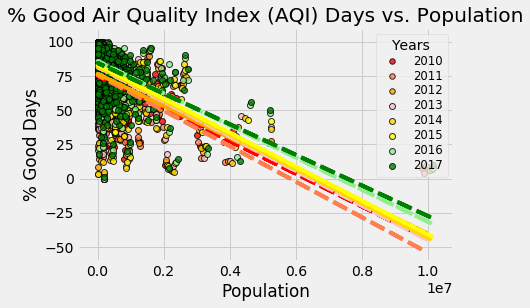

In [16]:
r = []
plt.scatter(county_pops2010, 
            good_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, good_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, good_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            good_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, good_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, good_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            good_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, good_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, good_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            good_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, good_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, good_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            good_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, good_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, good_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            good_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, good_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, good_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            good_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, good_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, good_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            good_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, good_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, good_days2017)
r.append(r_value*r_value)

plt.title("% Good Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Good Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
# plt.savefig("Figures/good_days_percent.png")

The mean r^2 value is: 0.14586180501712356


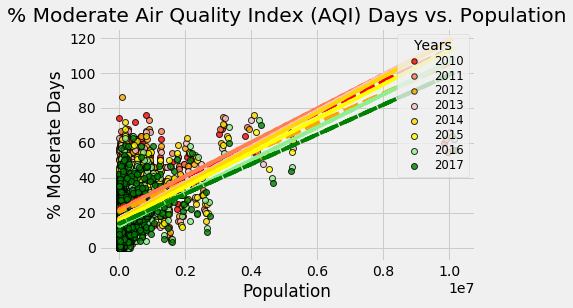

In [17]:

r = []
plt.scatter(county_pops2010, 
            moderate_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, moderate_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, moderate_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            moderate_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, moderate_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, moderate_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            moderate_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, moderate_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, moderate_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            moderate_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, moderate_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, moderate_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            moderate_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, moderate_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, moderate_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            moderate_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, moderate_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, moderate_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            moderate_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, moderate_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, moderate_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            moderate_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, moderate_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, moderate_days2017)
r.append(r_value*r_value)

plt.title("% Moderate Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Moderate Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
# plt.savefig("Figures/moderate_days_percent.png")

The mean r^2 value is: 0.11149691264820612


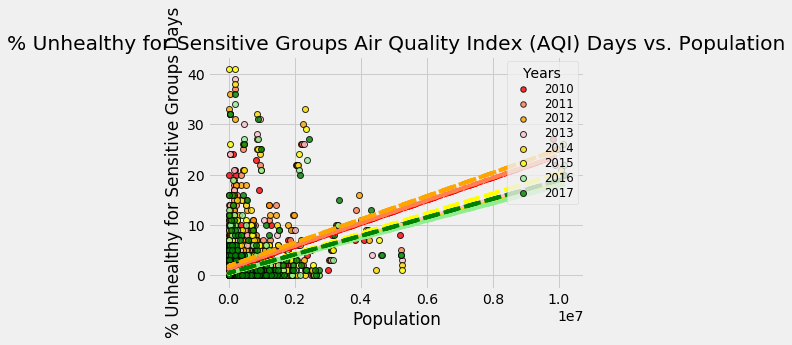

In [18]:

r = []
plt.scatter(county_pops2010, 
            unhealthys_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, unhealthys_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, unhealthys_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            unhealthys_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, unhealthys_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, unhealthys_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            unhealthys_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, unhealthys_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, unhealthys_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            unhealthys_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, unhealthys_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, unhealthys_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            unhealthys_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, unhealthys_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, unhealthys_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            unhealthys_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, unhealthys_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, unhealthys_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            unhealthys_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, unhealthys_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, unhealthys_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            unhealthys_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, unhealthys_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, unhealthys_days2017)
r.append(r_value*r_value)

plt.title("% Unhealthy for Sensitive Groups Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Unhealthy for Sensitive Groups Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
# plt.savefig("Figures/unhealthys_days_percent.png")

The mean r^2 value is: 0.026051752685252786


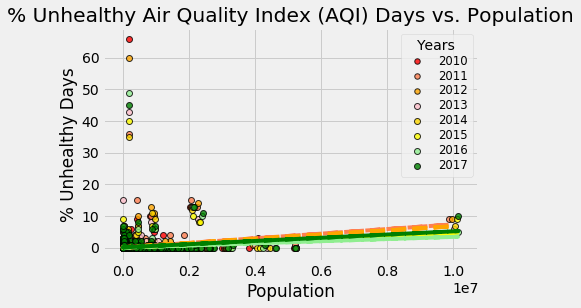

In [19]:


r = []
plt.scatter(county_pops2010, 
            unhealthy_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, unhealthy_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, unhealthy_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            unhealthy_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, unhealthy_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, unhealthy_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            unhealthy_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, unhealthy_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, unhealthy_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            unhealthy_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, unhealthy_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, unhealthy_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            unhealthy_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, unhealthy_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, unhealthy_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            unhealthy_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, unhealthy_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, unhealthy_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            unhealthy_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, unhealthy_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, unhealthy_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            unhealthy_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, unhealthy_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, unhealthy_days2017)
r.append(r_value*r_value)

plt.title("% Unhealthy Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Unhealthy Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()

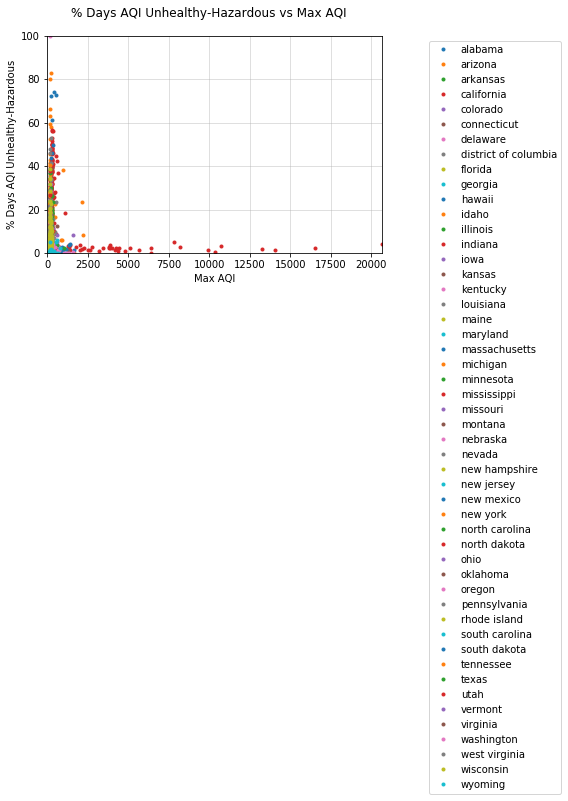

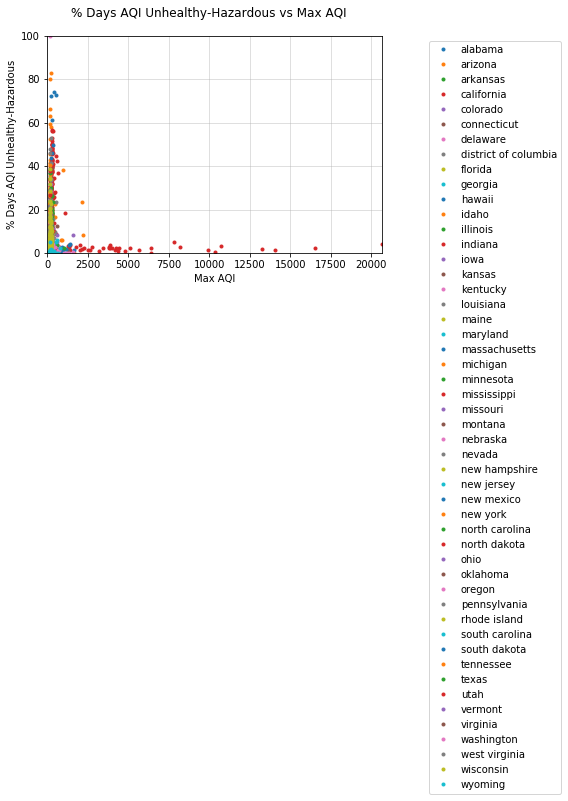

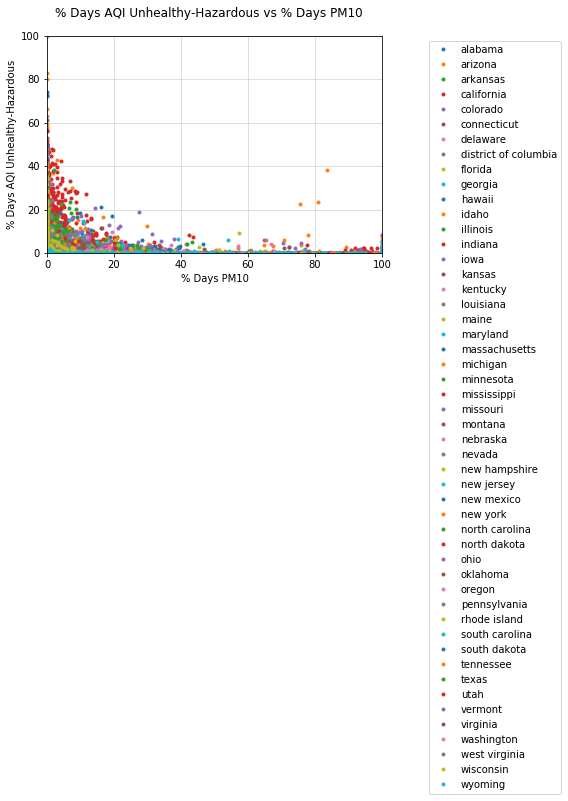

In [4]:
a = make_scatterplot(aqi, group_by=['State'], 
                 y='% Days AQI Unhealthy-Hazardous', x='Max AQI', linestyle='', return_obj=True)

b = make_scatterplot(aqi, group_by=['State'], 
                 y='% Days AQI Unhealthy-Hazardous', x='Max AQI', linestyle='', return_obj=True)

c = make_scatterplot(aqi, group_by=['State'], 
                 y='% Days AQI Unhealthy-Hazardous', 
                 x='% Days PM10', linestyle='')

In [5]:
# Read in aggregated data
df = pd.read_csv('clean_data/DATA_meds.csv', index_col=0)
df = df[['State', 'State Abbreviation', 'Year', 'Cancer Sites', 'Count', 
         'Median % Days AQI Unhealthy-Hazardous', 'Median Max AQI', 'Median 90th Percentile AQI', 
         'Median % Days CO', 'Median % Days NO2', 'Median % Days SO2',
         'Median % Days Ozone', 'Median % Days PM2.5', 'Median % Days PM10']]
print("Combined data headers:\n", df.keys().tolist())
df.head()

Combined data headers:
 ['State', 'State Abbreviation', 'Year', 'Cancer Sites', 'Count', 'Median % Days AQI Unhealthy-Hazardous', 'Median Max AQI', 'Median 90th Percentile AQI', 'Median % Days CO', 'Median % Days NO2', 'Median % Days SO2', 'Median % Days Ozone', 'Median % Days PM2.5', 'Median % Days PM10']


,State,State Abbreviation,Year,Cancer Sites,Count,Median % Days AQI Unhealthy-Hazardous,Median Max AQI,Median 90th Percentile AQI,Median % Days CO,Median % Days NO2,Median % Days SO2,Median % Days Ozone,Median % Days PM2.5,Median % Days PM10
0,alabama,AL,1999,All Invasive Cancer Sites Combined,19290,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
1,alabama,AL,1999,Oral Cavity and Pharynx,489,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
2,alabama,AL,1999,Lip,67,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
3,alabama,AL,1999,Tongue,110,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
4,alabama,AL,1999,Salivary Gland,44,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982


## Question 1: Is there a relationship between exposure to poor air quality and incidences of cancer?

In [6]:
# Remove summary data from df
cancer_type_df = df.loc[df['Cancer Sites'] != 'All Invasive Cancer Sites Combined']
print('Total number of different cancer sites in data:', len(cancer_type_df['Cancer Sites'].unique()))

# Find most prevalent cancers overall
top_cancers = cancer_type_df.groupby('Cancer Sites')[['Count']].sum().sort_values('Count', ascending=False)[:10].reset_index()
top_cancers = top_cancers['Cancer Sites'].tolist()
print('Top 10 most prevalent cancer sites:', ', '.join(top_cancers))

# Create df for scatterplot which contains only the most common cancers
top_cancer_type_df = cancer_type_df.loc[cancer_type_df['Cancer Sites'].isin(top_cancers)]
top_cancer_type_df.head()

Total number of different cancer sites in data: 103
Top 10 most prevalent cancer sites: Digestive System, Respiratory System, Male Genital System, Male and Female Breast, Female Breast, Lung and Bronchus, Prostate, Colon and Rectum, Urinary System, Colon excluding Rectum


,State,State Abbreviation,Year,Cancer Sites,Count,Median % Days AQI Unhealthy-Hazardous,Median Max AQI,Median 90th Percentile AQI,Median % Days CO,Median % Days NO2,Median % Days SO2,Median % Days Ozone,Median % Days PM2.5,Median % Days PM10
11,alabama,AL,1999,Digestive System,3738,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
15,alabama,AL,1999,Colon and Rectum,2249,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
16,alabama,AL,1999,Colon excluding Rectum,1644,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
35,alabama,AL,1999,Respiratory System,3613,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
38,alabama,AL,1999,Lung and Bronchus,3339,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982


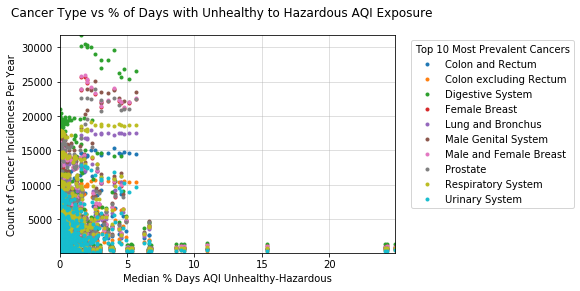

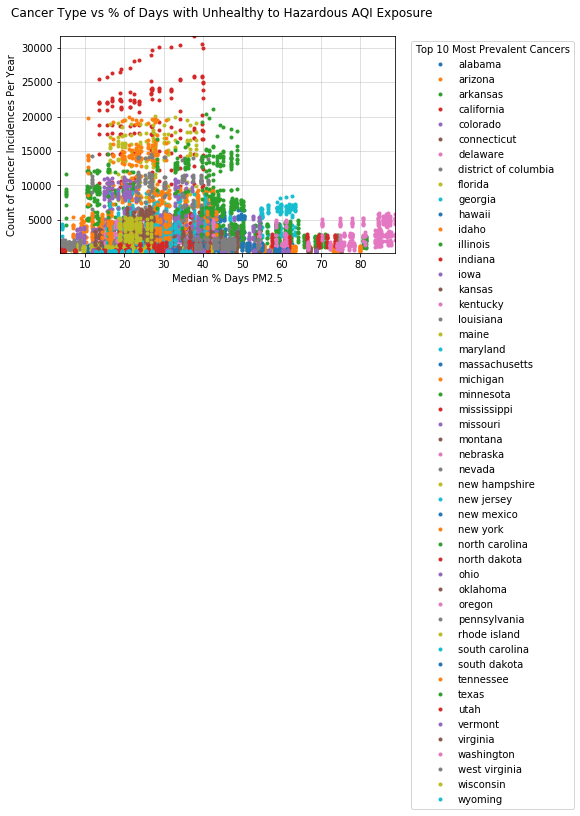

In [7]:
make_scatterplot(top_cancer_type_df, group_by=['Cancer Sites'], 
                 x='Median % Days AQI Unhealthy-Hazardous', y='Count', 
                 xlabel='Median % Days AQI Unhealthy-Hazardous', ylabel='Count of Cancer Incidences Per Year',
                 main_title='Cancer Type vs % of Days with Unhealthy to Hazardous AQI Exposure', 
                 legend_title='Top 10 Most Prevalent Cancers')

make_scatterplot(top_cancer_type_df, group_by=['State'], 
                 x='Median % Days PM2.5', y='Count', 
                 ylabel='Count of Cancer Incidences Per Year',
                 main_title='Cancer Type vs % of Days with Unhealthy to Hazardous AQI Exposure', 
                 legend_title='Top 10 Most Prevalent Cancers')

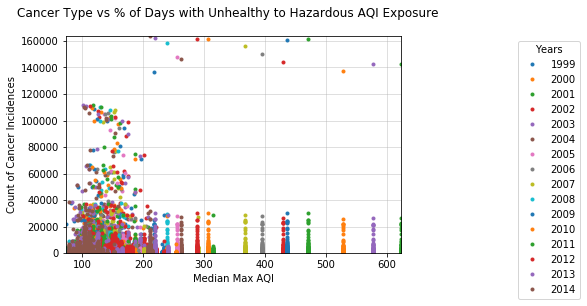

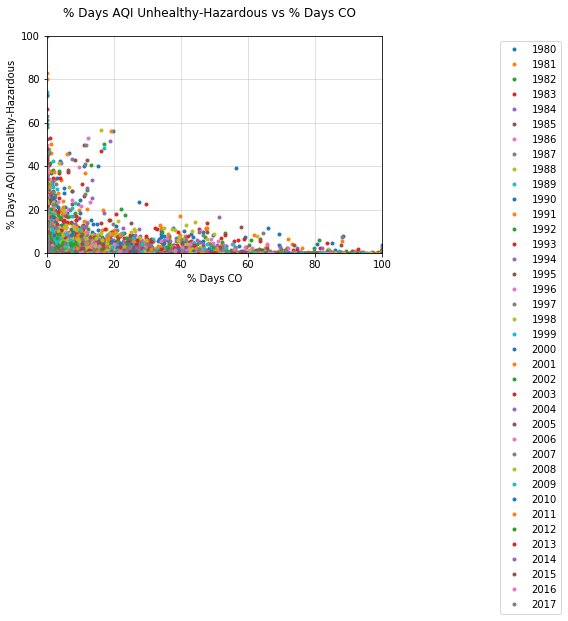

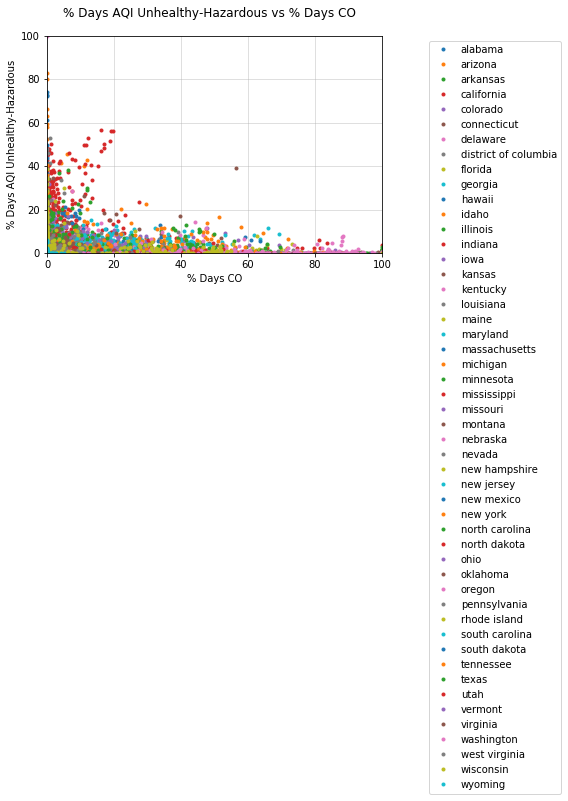

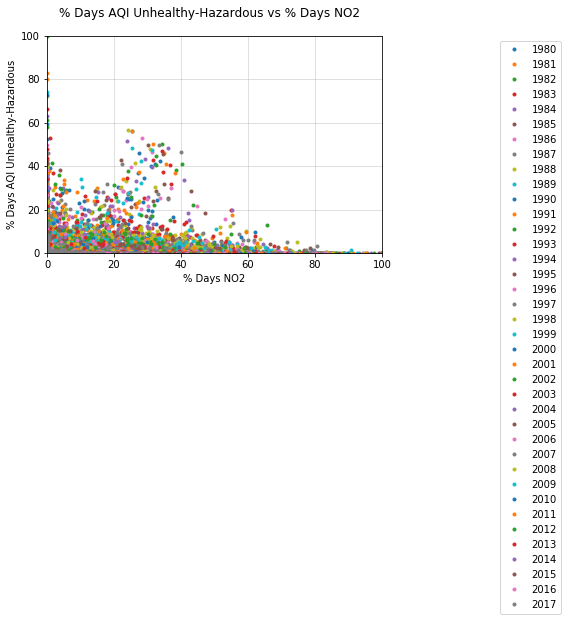

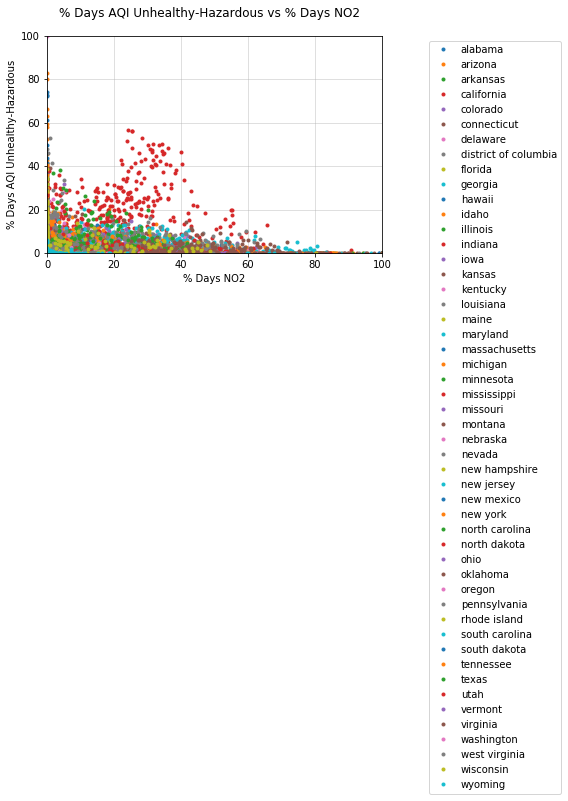

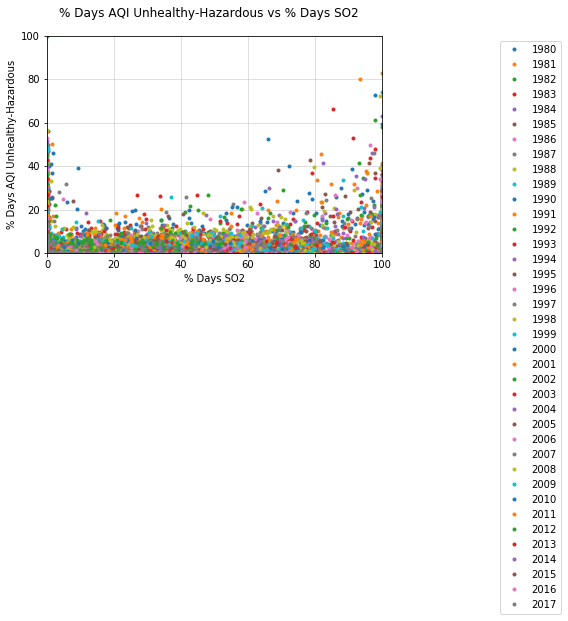

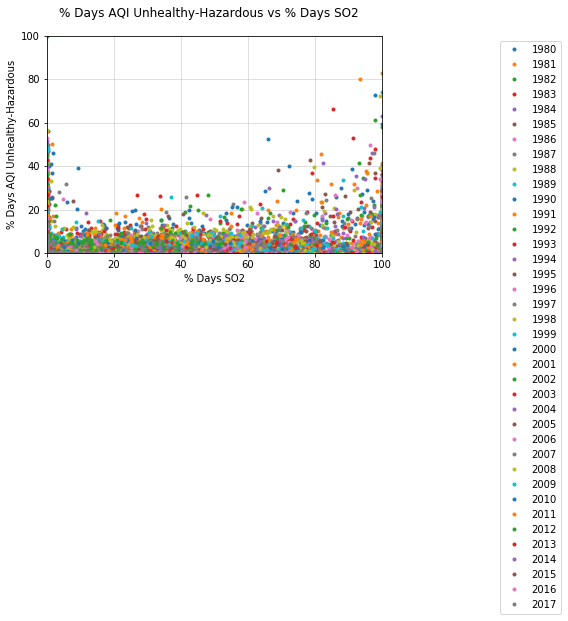

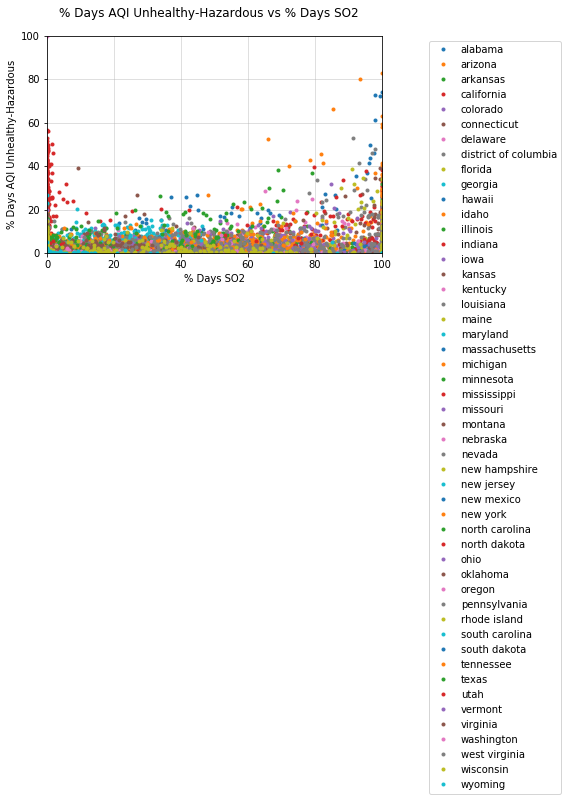

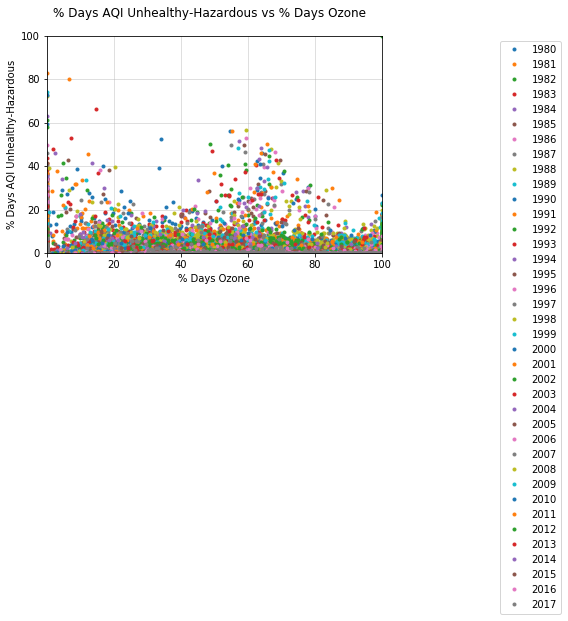

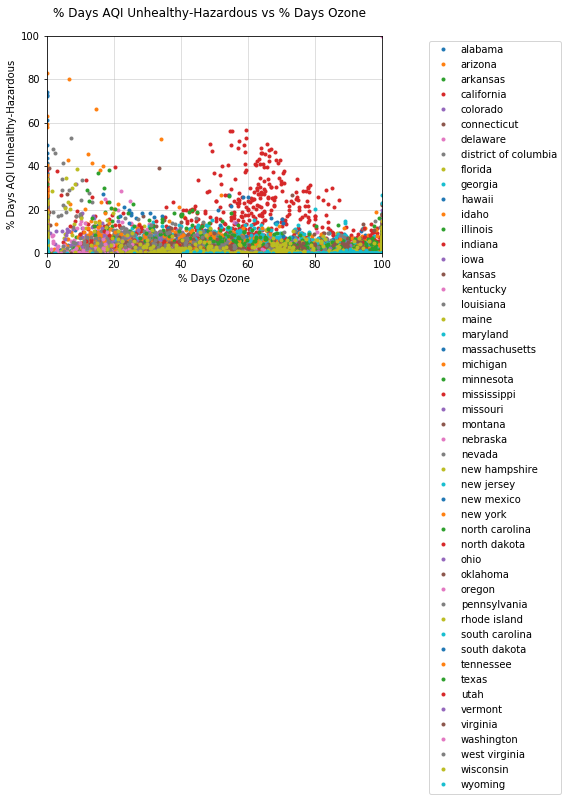

In [8]:
df.groupby(['Cancer Sites','Median % Days AQI Unhealthy-Hazardous'])[['Count']].mean().head()
df = df

make_scatterplot(df, group_by=['Year'], 
                 x='Median Max AQI',
                 y='Count', ylabel='Count of Cancer Incidences',
                 main_title='Cancer Type vs % of Days with Unhealthy to Hazardous AQI Exposure', 
                 legend_title='Years')

make_scatterplot(aqi, group_by=['Year'], x='% Days CO', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['State'], x='% Days CO', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['Year'], x='% Days NO2', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['State'], x='% Days NO2', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['Year'], x='% Days SO2', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['Year'], x='% Days SO2', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['State'], x='% Days SO2', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['Year'], x='% Days Ozone', y='% Days AQI Unhealthy-Hazardous', linestyle='')

make_scatterplot(aqi, group_by=['State'], x='% Days Ozone', y='% Days AQI Unhealthy-Hazardous', linestyle='')

--------
## Question 2: Does your probability of developing a certain type of cancer change depending on your geographic location in the US?

In [9]:
cancertypes = cancer.loc[cancer['Cancer Sites'] != 'All Invasive Cancer Sites Combined'].reset_index()
chi_df = {}
for name, group in cancertypes.groupby(['Year', 'State Abbreviation', 'Cancer Sites']):
#     print(name)
    yr, state, cancer_type = name
    if str(yr) not in chi_df.keys():
        chi_df[''.format(yr)] = [{state:[cancer_type, group.Count]}]
    else:
        chi_df[''.format(yr)].append({state:[cancer_type, group.Count]})
#     print(group.Count)
print(chi_df)

{'': [{'WY': ['Urinary System', 58201    227
Name: Count, dtype: int64]}]}


In [10]:
state_cancer = pd.read_csv('clean_data/state_cancer_1998_2014.csv', index_col=0)
# state_cancer.head()
state_cancer_type = state_cancer.loc[state_cancer['Cancer Sites'] != 'All Invasive Cancer Sites Combined']
# state_cancer_type = state_cancer_type.groupby(['State Abbreviation', 'Year', 'Cancer Sites'])[['Count']].max().reset_index()
# state_cancer_type = state_cancer_type.groupby(['State Abbreviation', 'Year', 'Cancer Sites'])[['Count']].max().sort_values(['Year','Count'], ascending=False)#.groupby('State')

# Get rid of summary data
state_cancer_type = state_cancer.loc[state_cancer['Cancer Sites'] != 'All Invasive Cancer Sites Combined']

# Group by state, year, and cancer type
state_cancer_type = state_cancer_type.groupby(['State Abbreviation', 'Year', 'Cancer Sites'])[['Count']].sum().reset_index()

# All ranked by descending count
state_cancer_type = state_cancer_type.sort_values('Count', ascending=False).reset_index()

state_cancer_type = state_cancer_type.groupby(['State Abbreviation', 'Year', ])[['Cancer Sites','Count']].max().reset_index()

# state_cancer_type

state_cancer_type.head()

,State Abbreviation,Year,Cancer Sites,Count
0,AK,1999,Urinary System,362
1,AK,2000,Urinary System,395
2,AK,2001,Urinary System,416
3,AK,2002,Urinary System,422
4,AK,2003,Urinary System,412


## Question 3: How well can you predict [cancer instances/risk] from AQI and year?
--------
- Data Analysis: Linear Regression
    - Response variable: cancer (rate?)
    - Explanatory variables: AQI, state, year, type of pollutant

In [11]:
plt.style.use('seaborn')

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [16]:
cancer_types = df.loc[df['Cancer Sites'] != 'All Invasive Cancer Sites Combined'].reset_index()

# Rename columns
newcols = {'State':'state', 'State Abbreviation':'state_abbrev', 'Year':'year', 
           'Median Max AQI':'aqi_max', 'Median 90th Percentile AQI':'aqi_90th',
           'Median % Days AQI Unhealthy-Hazardous':'aqi_pcnt_days_unhealthy', 
           'Median % Days CO':'pcnt_days_co', 'Median % Days NO2':'pcnt_days_no2',
           'Median % Days SO2':'pcnt_days_so2', 'Median % Days Ozone':'pcnt_days_ozone', 
           'Median % Days PM2.5':'pcnt_days_pm2pt5', 'Median % Days PM10':'pcnt_days_pm10',
           'Cancer Sites':'cancer_type', 'Count':'cancer_counts'}
cancer_types.rename(columns = newcols, inplace = True)

cancer_types = cancer_types[['state', 'state_abbrev', 'year', 'cancer_type',
       'cancer_counts', 'aqi_pcnt_days_unhealthy', 'aqi_max', 'aqi_90th',
       'pcnt_days_co', 'pcnt_days_no2', 'pcnt_days_so2', 'pcnt_days_ozone',
       'pcnt_days_pm2pt5', 'pcnt_days_pm10']]
print(cancer_types.keys())
cancer_types.head()

Index(['state', 'state_abbrev', 'year', 'cancer_type', 'cancer_counts',
       'aqi_pcnt_days_unhealthy', 'aqi_max', 'aqi_90th', 'pcnt_days_co',
       'pcnt_days_no2', 'pcnt_days_so2', 'pcnt_days_ozone', 'pcnt_days_pm2pt5',
       'pcnt_days_pm10'],
      dtype='object')


,state,state_abbrev,year,cancer_type,cancer_counts,aqi_pcnt_days_unhealthy,aqi_max,aqi_90th,pcnt_days_co,pcnt_days_no2,pcnt_days_so2,pcnt_days_ozone,pcnt_days_pm2pt5,pcnt_days_pm10
0,alabama,AL,1999,Oral Cavity and Pharynx,489,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
1,alabama,AL,1999,Lip,67,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
2,alabama,AL,1999,Tongue,110,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
3,alabama,AL,1999,Salivary Gland,44,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982
4,alabama,AL,1999,Floor of Mouth,29,1.725947,144.954545,89.909091,0.535731,0.0,11.765212,25.312181,40.137894,22.248982


In [17]:
# Fitted linear regression model
variables = ['state', 'year', 'cancer_type','aqi_90th', 'pcnt_days_co',
       'pcnt_days_no2', 'pcnt_days_so2', 'pcnt_days_ozone', 'pcnt_days_pm2pt5',
       'pcnt_days_pm10']
model_f = 'cancer_counts ~ {}'.format(' + '.join(variables))

model = smf.ols(formula=model_f, data=cancer_types)
model_fit = model.fit()
model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Ordinary least squares
==========================================================================================================================
Model:                                 OLS                               Adj. R-squared:                      0.575       
Dependent Variable:                    cancer_counts                     AIC:                                 1131592.3665
Date:                                  2018-06-16 16:31                  BIC:                                 1133038.7824
No. Observations:                      65970                             Log-Likelihood:                      -5.6564e+05 
Df Model:                              158                               F-statistic:                         565.5       
Df Residuals:                          65811                             Prob (F-statistic):                  0.00        
R-squared:                             0.576                             Scale:                               1.6443e+06  
--------------------------------------------------------------------------------------------------------------------------
                                                                   Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -16.0118   2.4847  -6.4443 0.0000   -20.8818   -11.1419
state[T.arizona]                                                    98.3278  54.3006   1.8108 0.0702    -8.1013   204.7570
state[T.arkansas]                                                 -354.5218  53.6213  -6.6116 0.0000  -459.6195  -249.4241
state[T.california]                                               3022.4953  52.5898  57.4730 0.0000  2919.4192  3125.5714
state[T.colorado]                                                  -92.1056  56.6765  -1.6251 0.1041  -203.1916    18.9804
state[T.connecticut]                                               -60.7142  54.0394  -1.1235 0.2612  -166.6315    45.2031
state[T.delaware]                                                 -837.0366  55.7081 -15.0254 0.0000  -946.2244  -727.8488
state[T.district of columbia]                                    -1096.7282  72.1377 -15.2033 0.0000 -1238.1180  -955.3384
state[T.florida]                                                  1977.8625  49.1592  40.2338 0.0000  1881.5105  2074.2145
state[T.georgia]                                                   422.4388  47.8274   8.8326 0.0000   328.6970   516.1805
state[T.hawaii]                                                   -742.8284  68.4485 -10.8524 0.0000  -876.9875  -608.6694
state[T.idaho]                                                    -746.9563  58.7881 -12.7059 0.0000  -862.1810  -631.7315
state[T.illinois]                                                 1043.3603  53.3973  19.5396 0.0000   938.7017  1148.0190
state[T.indiana]                                                   221.6621  57.5646   3.8507 0.0001   108.8354   334.4888
state[T.iowa]                                                     -226.6926  50.1919  -4.5165 0.0000  -325.0687  -128.3164
state[T.kansas]                                                   -328.4461  53.7234  -6.1137 0.0000  -433.7440  -223.1483
state[T.kentucky]                                                   35.6645  49.7228   0.7173 0.4732   -61.7921   133.1212
state[T.louisiana]                                                   1.8197  48.8559   0.0372 0.9703   -93.9379    97.5774
state[T.maine]                                                    -549.6405  58.5777  -9.3831 0.0000  -664.4529  -434.8282
state[T.maryland]                                                  175.1528  52.4296   3.3407 0.0008    72.3909   277.9148
state[T.massachusetts]                                       

In [18]:
# Calculations for plots

# fitted values
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

KeyboardInterrupt: 

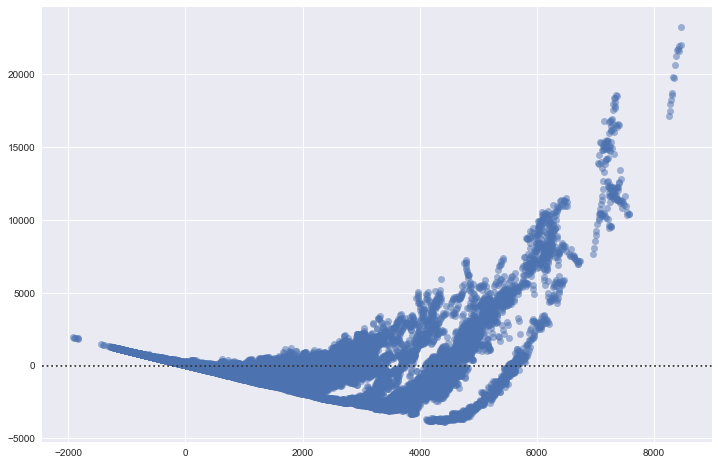

In [15]:
# Residual plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'cancer_counts', data=cancer_types, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

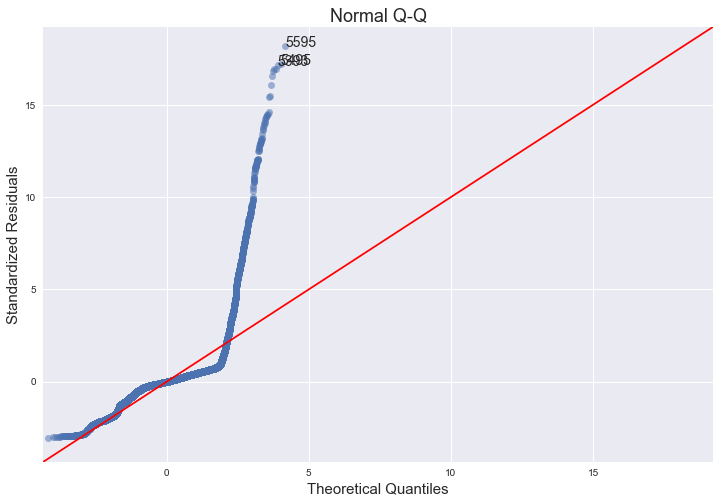

In [19]:
# QQ plot - shows how well the distribution of residuals fit the normal distribution

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));


KeyboardInterrupt: 

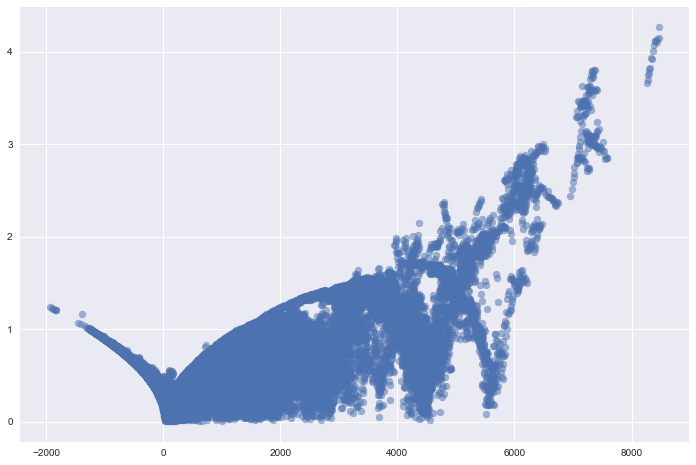

In [20]:
# Scale-location plot - residual plot showing spread to asses heteroscedasticity
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));


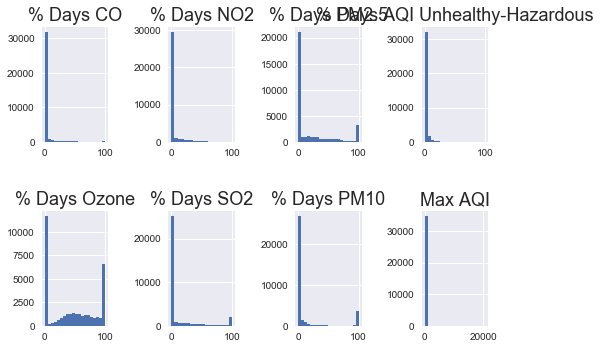

In [21]:
f, ax = plt.subplots(2,4)

ax[0,0].set_title('% Days CO')
ax[0,0].hist(aqi['% Days CO'], bins=20)

ax[1,0].set_title('% Days Ozone')
ax[1,0].hist(aqi['% Days Ozone'], bins=20)

ax[0,1].set_title('% Days NO2')
ax[0,1].hist(aqi['% Days NO2'], bins=20)

ax[1,1].set_title('% Days SO2')
ax[1,1].hist(aqi['% Days SO2'], bins=20)

ax[0,2].set_title('% Days PM2.5')
ax[0,2].hist(aqi['% Days PM2.5'], bins=20)

ax[1,2].set_title('% Days PM10')
ax[1,2].hist(aqi['% Days PM10'], bins=20)#, normed=True)

ax[0,3].set_title('% Days AQI Unhealthy-Hazardous')
ax[0,3].hist(aqi['% Days AQI Unhealthy-Hazardous'], bins=20)#, normed=True)

ax[1,3].set_title('Max AQI')
ax[1,3].hist(aqi['Max AQI'], bins=20)#, normed=True)

# f.suptitle('Histograms of Pollutant Data')
# plt.tight_layout()
# aqi['% Days Ozone'].hist(bins=20)
plt.subplots_adjust(hspace=0.6, wspace=0.9)
plt.show()

---------------
# Conclusions

### [Question 1]

### [Question 2]

### [Question 3]